In [7]:
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.utils import draw_bounding_boxes
import os
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt

In [8]:
os.mkdir('/kaggle/working/african-wildlife')
os.mkdir('/kaggle/working/african-wildlife/train/')
os.mkdir('/kaggle/working/african-wildlife/test/')
os.mkdir('/kaggle/working/african-wildlife/valid')


FileExistsError: [Errno 17] File exists: '/kaggle/working/african-wildlife'

In [10]:
os.mkdir('/kaggle/working/african-wildlife/train/images')


FileExistsError: [Errno 17] File exists: '/kaggle/working/african-wildlife/train/images'

In [12]:
os.mkdir('/kaggle/working/african-wildlife/valid')


FileExistsError: [Errno 17] File exists: '/kaggle/working/african-wildlife/valid'

In [13]:
a ='buffalo'
b = '001'

os.path.exists("/kaggle/input/african-wildlife/" + a +'/'+ b+".jpg") 

True

In [ ]:
# Directory containing your text files
class file:
    def __init__(self):
        self.df = 0
        
        self.i=0
    def csv_file_creator(self,input1,input2):

        txt_files_directory = '/kaggle/input/african-wildlife/' + str(input2)

# List to store data from each text file
        data_list = []

# Loop through each text file in the directory
        for filename in os.listdir(txt_files_directory):
            if filename.endswith('.txt'):
                file_path = os.path.join(txt_files_directory, filename)
        # Read data from the text file (adjust parsing logic based on your format)
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    for line in lines:
                # Assuming YOLO format: img_path class_label x_center y_center width height
                        x,_ = filename.split('.txt')

                        if os.path.exists(txt_files_directory+'/'+x+ ".jpg") == True:
                            img_path = os.path.join(input2,x+".jpg")
                        else:
                            img_path = os.path.join(input2,x+".JPG")
                        class_label = int(line.strip().split(' ')[0])
                        bbox1 = float(line.strip().split(' ')[1])
                        bbox2 = float(line.strip().split(' ')[2])
                        bbox3 = float(line.strip().split(' ')[3])
                        bbox4 = float(line.strip().split(' ')[4])

                # Append data to the list
                        data_list.append((img_path, class_label, bbox1, bbox2, bbox3, bbox4))
            else:
                continue

# Convert the list of tuples to a DataFrame
        if self.i ==0:
            df = pd.DataFrame(data_list, columns=['img_path', 'class_label', 'bbox1', 'bbox2', 'bbox3', 'bbox4'])
            self.i+=1
# Save the DataFrame to a CSV file
            csv_output_path = '/kaggle/working/african-wildlife/dataset.csv'
            df = df.to_csv(csv_output_path, index=False)
        else:
            csv_output_path = '/kaggle/working/african-wildlife/dataset.csv'

            df = pd.read_csv('/kaggle/working/african-wildlife/dataset.csv')
            df1 = pd.DataFrame(data_list, columns=['img_path', 'class_label', 'bbox1', 'bbox2', 'bbox3', 'bbox4'])
            df = pd.merge(df,df1, on =['img_path', 'class_label', 'bbox1', 'bbox2', 'bbox3', 'bbox4'], how = 'outer') 
            df = df.to_csv(csv_output_path, index=False)


In [ ]:
x = file()
x.csv_file_creator('train','buffalo')
x.csv_file_creator('train','elephant')
x.csv_file_creator('train','zebra')
x.csv_file_creator('train','rhino')

In [ ]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/kaggle/working/african-wildlife/dataset.csv')
train,test = train_test_split(df,test_size=0.2,shuffle=True)
train = train.to_csv('/kaggle/working/african-wildlife/train/dataset.csv', index=False)
test = test.to_csv('/kaggle/working/african-wildlife/test/dataset.csv', index=False)

In [ ]:
df = pd.read_csv('/kaggle/working/african-wildlife/test/dataset.csv')
df

In [ ]:
df.class_label.unique()


In [ ]:
def modify_labels(path):
    df = pd.read_csv(path)
    
    df['class_label'] = df['class_label'].replace([0,1,3,2], [4,1,3,2])
    df.to_csv(path, index=False)


In [ ]:
modify_labels('/kaggle/working/african-wildlife/test/dataset.csv')
modify_labels('/kaggle/working/african-wildlife/train/dataset.csv')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,csv_file, root_dir,transform = None):
        self.annotations= pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,idx):
        image_path = os.path.join(self.root_dir,self.annotations.iloc[idx,0])
        img = Image.open(image_path)
        class_label = self.annotations.iloc[idx,1]

        class_label = torch.as_tensor(class_label)

        x_center =  float(self.annotations.iloc[idx, 2])
        y_center =  float(self.annotations.iloc[idx, 3])
        width = float(self.annotations.iloc[idx, 4])
        height = float(self.annotations.iloc[idx, 5])
        if self.transform:
            img = self.transform(img)


        image_width, image_height =224, 224

        x_min = (x_center - width/ 2) *image_width
        y_min = (y_center - height / 2)*image_height
        x_max = (x_center + width / 2)*image_width
        y_max = (y_center + height / 2)*image_height
        target = {}
        bbox =  [x_min,y_min,x_max,y_max]
        bbox = torch.as_tensor(bbox)
        target['boxes']= torch.unsqueeze(bbox,0)
        target['labels'] = torch.unsqueeze(class_label,0)
        return img,target

# Calculate mean and std for your custom dataset

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
train = pd.read_csv('/kaggle/working/african-wildlife/train/dataset.csv')
train

In [ ]:
train_set=CustomDataset(csv_file= '/kaggle/working/african-wildlife/train/dataset.csv',root_dir='/kaggle/input/african-wildlife',transform=transform)
val_set=CustomDataset(csv_file= '/kaggle/working/african-wildlife/test/dataset.csv',root_dir='/kaggle/input/african-wildlife',transform=transform)

In [ ]:
train_set

In [ ]:
a,c = train_set[11]
c['labels'].size()

In [ ]:
import matplotlib.pyplot as plt
# plot images

image ,label = train_set[10]

print('label: ',label['labels'].tolist())
print(image.shape)



image =(image.clamp(0, 1) * 255).to(torch.uint8)
img=draw_bounding_boxes(image, label['boxes'], colors=(255,255,0))

img = torchvision.transforms.ToPILImage()(img)
plt.imshow(img)


In [ ]:
df["class_label"].unique()

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(999)
j=0
for i in range(0,36):

    ax1 = plt.subplot(6,6,j+1)

    image , label = train_set[i]
    image =(image.clamp(0, 1) * 255).to(torch.uint8)

    img=draw_bounding_boxes(image, label['boxes'], colors=(255,0,0))
    img = torchvision.transforms.ToPILImage()(img)
    plt.title(label['labels'].tolist())
    plt.axis(False)
    plt.imshow(img)
    j+=1
plt.show()

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
num_classes =5


In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor= FastRCNNPredictor(in_features,num_classes)

In [ ]:
def collate_fn(data):
    return tuple(zip(*data))


In [ ]:
batchsize=10

traindlr = DataLoader(train_set,batchsize,shuffle =True,collate_fn=collate_fn) #for train set
valdlr = DataLoader(val_set,1,batchsize,collate_fn=collate_fn)

In [ ]:
net = model.to('cuda')  # Creating object for LeNet() model and passing it to CPU
box_loss_fn = nn.BCEWithLogitsLoss()
labels_loss_fn = nn.BCEWithLogitsLoss()

opt = optim.SGD(net.parameters(),lr=0.01, weight_decay=0.0001) #optimizer for updating the model


In [ ]:
device  = torch.device('cuda')

In [ ]:

def label_prediction(dataloader):

    label_list=[]
    predict_list=[]
    for imgs , annotations in dataloader:
        ann_ls = []
        pred_ls=[]
        imgs = list(img.to(device)for img in imgs)
        i=0
        for d in annotations:
            image = [imgs[i]]
            
        

            output = make_prediction(net,image,0.5)
            pred_label = output[0]['labels']
            ann_label = d['labels'].to(device)
            for k in range(len(pred_label)):
                pred_ls.append(pred_label[k].item())
            for j in range(len(ann_label)):
                ann_ls.append(ann_label[j].item())
            #for true positive    
            
            if str(pred_label.size()) == 'torch.Size([0])':
                label_list.append(ann_label.tolist()[0])
                predict_list.append(0)
                
            elif ann_label.to(device)[0] in pred_label.to(device):    
                a = ann_label.to('cpu')
                label_list.append(a.tolist()[0])
                predict_list.append(a.tolist()[0])

            else:
                label_list.append(ann_label.to('cpu').tolist()[0])
                predict_list.append(pred_label.to('cpu').tolist()[0])
            i+=1

            ann_ls = []
            pred_ls=[]
    return label_list,predict_list

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [ ]:
def fit(max_epochs):
    batches = len(traindlr)
    for epoch in range(max_epochs):
        total_loss= 0
        net.train()
        #training pahase
        for  imgs, annotations in (traindlr):  
            

            imgs = [img.to(device) for img in imgs]
            annotations = [{k: v.to(device) for k , v in t.items()} for t in annotations]
            
            outputs = net(imgs,annotations)
            
            loss = sum(v for v in outputs.values())   # Loss forward pass
            opt.zero_grad()                                          # Reset the gradient in every iteration

            loss.backward()                                          # Loss backaed pass

            opt.step()                                               # Update all the parameters by the given learnig rule
            total_loss += loss.cpu().detach().numpy()
        ann_label,predict_label= label_prediction(traindlr)
        train_acc = accuracy_score(ann_label,predict_label)
        print('Train accuracy : ' + str(train_acc))#prints accuracy training and validation phase
        print( 'Train loss: '+ str(total_loss/batches))
        
fit(2)
torch.save(net, 'fastrcnn3.pt')

In [ ]:
net = torch.load('fastrcnn3.pt')

In [ ]:
net = net.to('cuda')  # Creating object for LeNet() model and passing it to CPU
opt = optim.SGD(net.parameters(),lr=0.01, weight_decay=0.0001)

In [ ]:
loss_arr = []
loss_epoch_arr = []
val_loss_arr = []
acc_arr=[]
precision_arr=[]
recall_arr=[]
f1_arr=[]
val_acc_arr=[]
val_recall_arr=[]
val_f1_arr=[]
val_precision_arr=[]

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:

def train_test_fit(max_epochs):
    best_model =0
    best_val_acc=0
    batches = len(traindlr)
    val_batches = len(valdlr)
    for epoch in range(max_epochs):
        total_loss= 0
        net.train()
        #training pahase
        for  imgs, annotations in (traindlr):  
            

            imgs = [img.to(device) for img in imgs]
            annotations = [{k: v.to(device) for k , v in t.items()} for t in annotations]
            
            outputs = net(imgs,annotations)
            
            loss = sum(v for v in outputs.values())   # Loss forward pass
            opt.zero_grad()                                          # Reset the gradient in every iteration
            loss.backward()                                          # Loss backaed pass
            opt.step()                                               # Update all the parameters by the given learnin+g rule
            total_loss += loss.cpu().detach().numpy()
        loss_arr.append(total_loss)
        val_loss=0
        
        net.eval() 
        with torch.no_grad():
            for imgs, annotations in valdlr:
                imgs = list(img.to(device) for img in imgs)
                ann = annotations
                pred = make_prediction(net, imgs, 0.5)
                pred_label = pred[0]['labels'].to(torch.float)
                ann_label = ann[0]['labels'].to(torch.float)
                net.train()
                annotations = [{k: v.to(device) for k , v in t.items()} for t in annotations]
                loss = sum(v for v in outputs.values())
                outputs = net(imgs,annotations)
                val_loss += loss.cpu().detach().numpy()
        val_loss_arr.append(val_loss)                                 # to store validation loss
        ann_label,predict_label= label_prediction(traindlr)
        val_ann_label,val_predict_label= label_prediction(valdlr)


        val_acc = accuracy_score(val_ann_label,val_predict_label)
        train_acc = accuracy_score(ann_label,predict_label)
        print('Val accuracy: '+  str(val_acc)+'  ,  Train accuracy : ' + str(train_acc))#prints accuracy training and validation phase
        acc_arr.append(train_acc)
        val_acc_arr.append(val_acc)
        
        if val_acc >best_val_acc:
            best_model = net
            best_val_acc = val_acc
            torch.save(best_model, 'fastrcnn.pt')
        val_pre = precision_score(val_ann_label,val_predict_label, average = 'macro')
        train_pre = precision_score(ann_label, predict_label,average = 'macro')
        precision_arr.append(train_pre)
        val_precision_arr.append(val_pre)
        
        
        val_f1 = f1_score(val_ann_label,val_predict_label,average = 'macro')
        train_f1 = f1_score(ann_label,predict_label,average = 'macro')        
        f1_arr.append(train_f1)
        val_f1_arr.append(val_f1)
        
        val_recall = recall_score(val_ann_label,val_predict_label,average = 'macro')
        train_recall = recall_score(ann_label,predict_label,average = 'macro')          
        recall_arr.append(train_recall)
        val_recall_arr.append(val_recall)
                
        print('Val loss: '+ str(val_loss/val_batches) +'  ,  Train loss: '+ str(total_loss/batches))
            #prints accuracy training and validation phase

max_epochs = 25



train_test_fit(max_epochs)

In [ ]:
max_epochs = 25

epoch_arr= []
for i in range(max_epochs):
    epoch_arr.append(i+1)
plt.plot(epoch_arr,acc_arr,label = 'Train_accuracy')
plt.plot(epoch_arr,val_acc_arr,label = 'Valid_accuracy')
plt.legend()

In [ ]:
max_epochs = 25
val_loss_array=[]
epoch_arr= []
for i in range(1,max_epochs+1):
    epoch_arr.append(i)
    val_loss_array.append(val_loss_arr[i-2])

plt.plot(epoch_arr,loss_arr,label = 'Train_loss')
plt.plot(epoch_arr,val_loss_array,label = 'Valid_loss')
plt.legend()

In [ ]:
fig, axs= plt.subplots(2,2)
axs[0,0].set_title('Accuracy')
axs[0,0].plot(epoch_arr, acc_arr)
axs[0,0].plot(epoch_arr, val_acc_arr)

axs[0,1].set_title('precision')
axs[0,1].plot(epoch_arr, precision_arr)
axs[0,1].plot(epoch_arr, val_precision_arr)

axs[1,0].set_title('f1')
axs[1,0].plot(epoch_arr, f1_arr)
axs[1,0].plot(epoch_arr, val_f1_arr)

axs[1,1].set_title('recall')
axs[1,1].plot(epoch_arr, recall_arr)
axs[1,1].plot(epoch_arr, val_recall_arr)

# functions

In [1]:
net = torch.load('fastrcnn.pt')
net = net.to('cuda')
net.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

/tmp/ipykernel_34/2822420774.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(3,3,i+1)


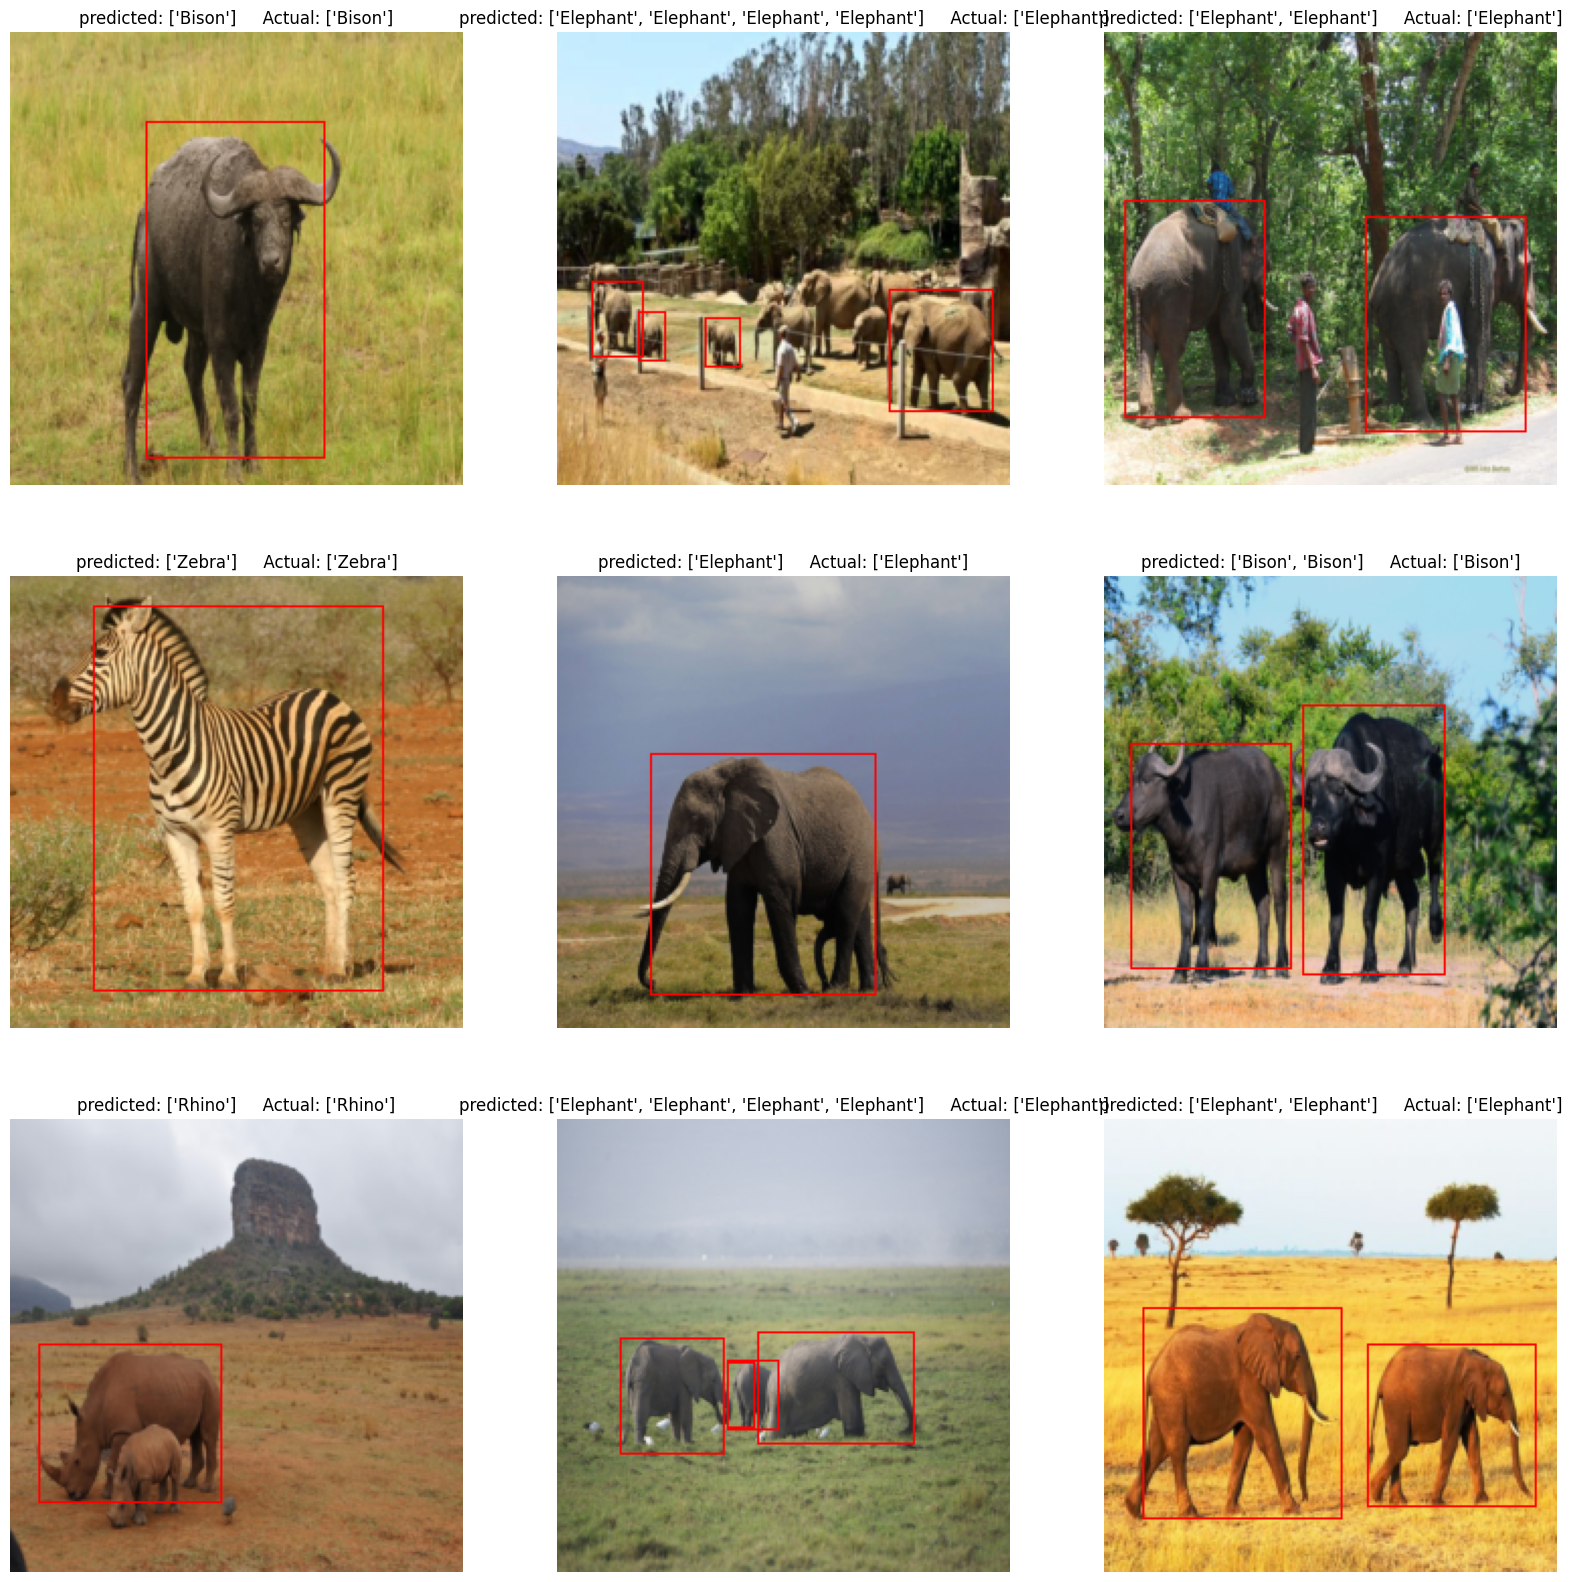

In [2]:
import matplotlib.pyplot as plt
with torch.no_grad(): 
    i=0
    # batch size of the test set = 1
    plt.figure(figsize=(20,20))

    
    plt.subplot(999)

    for imgs, annotations in valdlr:
        loss =0 
        imgs = list(img.to(device) for img in imgs)
        ann = annotations
        pred = make_prediction(net, imgs, 0.5)
        pred_label = pred[0]['labels'].to(torch.float)
        ann_label = ann[0]['labels'].to(torch.float)
        ax1 = plt.subplot(3,3,i+1)
     
        if str(ann_label) != 'tensor([0.])':
            i+=1

           # if str(pred_label.size()) == 'torch.Size([0])':
                #pred_label = ann_label
            for j in range(len(pred_label.to(device))):
                k = 0
                if pred_label[[k]].to(device) == ann_label.to(device):
                    #print(pred_label[[k]].to(device))
                    loss = labels_loss_fn(pred_label[[k]].to(device), ann_label.to(device)).item()
                elif k<len(pred_label.to(device)):
                    k+=1
                else:
                    loss = labels_loss_fn(pred_label[[j]].to(device), ann_label.to(device)).item()
            #print(loss)
            img =(imgs[0].clamp(0, 1) * 255).to(torch.uint8)
            img=draw_bounding_boxes(img, pred[0]['boxes'], colors=(255,0,0))
            img = torchvision.transforms.ToPILImage()(img)
            pred_values,actual_values = labels_to_values(ann[0]['labels'].tolist(),pred[0]['labels'].tolist())
            plt.title("predicted: " + str(pred_values) + "     Actual: " + str(actual_values))
            plt.axis(False)
            plt.imshow(img)

            
            if i == 9:
                break
    plt.show()

In [3]:
from sklearn.metrics import accuracy_score,f1_score
val_ann_label, val_predict_label = label_prediction(valdlr)

accuracy_score(val_ann_label,val_predict_label)

0.9962756052141527

In [4]:
precision_score(val_predict_label,val_ann_label,average='weighted')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9944361889116701

In [5]:
recall_score(val_predict_label,val_ann_label,average='macro')

0.7981818181818182

In [5]:
f1_score(val_predict_label,val_ann_label,average='weighted')

0.9953459676711958

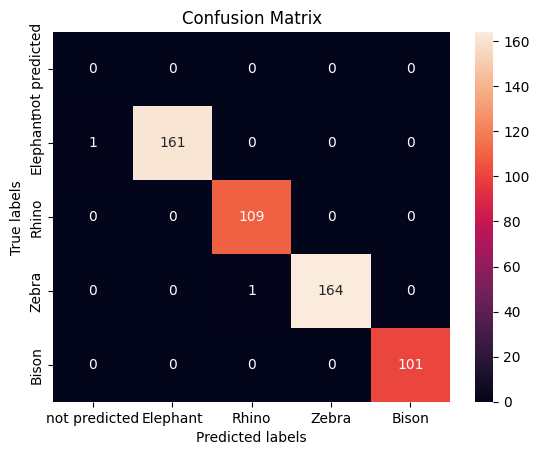

In [6]:
import seaborn as sns
ax=plt.subplot()

sns.heatmap(confusion_matrix(val_ann_label,val_predict_label),annot=True,fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not predicted','Elephant','Rhino','Zebra','Bison']); ax.yaxis.set_ticklabels(['not predicted','Elephant','Rhino','Zebra','Bison']);